# [NML24] Assignment 1: Classical Graph Machine Learning and Analysis

TAs: [Ali Hariri](ali.hariri@epfl.ch) and [Ortal Senouf](ortal.senouf@epfl.ch)

## Students

* Team: `<your team number>`
* Students: `<student1>`, `<student2>`

## Instructions

> ⚠️ **Read carefully before starting**

**Deadline:**

**Grading:**
* The integrality of Assignment 1 will be scaled to 100% and will amount to 1/3 of the overall assignments score.
* The total number of points is **59**, the points for each exercise are stated in the instructions.
* All team members will receive the same grade based on the team solution.
* Collaboration between team members is encouraged. No collaboration between teams is allowed.


**Expected output:**

You will have coding and theoretical questions. Coding exercises shall be solved within the specified space:
```python
# Your solution here ###########################################################
...
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
```
Sometimes we provide variable names, such as `x = ...`; do not change names and stick to hinted typing, as they will be reused later.
Within the solution space, you can declare any other variable of function that you might need, but anything outside these lines shall not be changed, or it will invalidate your answers.

Theoretical questions shall be answered in the following markdown cell. The first line will be
```markdown
**Your answer here:**
...
```

**Solutions:**
* Your submission is self-contained in the `.ipynb` file.

* Code has to be clean and readable. Provide meaningful variable names and comment where needed.

* Textual answers in [markdown cells][md_cells] shall be short: one to two
  sentences. Math shall be written in [LaTeX][md_latex].
    **NOTE**: handwritten notes pasted in the notebook are ignored

* You cannot import any other library than we imported, unless explicitly stated.

* Make sure all cells are executed before submitting. I.e., if you open the notebook again it should show numerical results and plots. Cells not run are ignored.

* Execute your notebook from a blank state before submission, to make sure it is reproducible. You can click "Kernel" then "Restart Kernel and Run All Cells" in Jupyter. We might re-run cells to ensure that the code is working and corresponds to the results.

[md_cells]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html
[md_latex]: https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html#LaTex-equations

## Objective

The purpose of this assignment is to explore and compare classical graph analysis and learning methods for different tasks on graphs. This assignment covers the material provided in lectures 1-4.

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from grakel import GraphKernel
from grakel.utils import graph_from_networkx
seed = 42


# **Part 1: Graph Classification [25 pts]**

## Dataset
In this part we will work on the MUTAG dataset. The MUTAG dataset is a commonly used benchmark dataset in the field of graph classification and machine learning on graphs. It consists of 188 chemical compounds represented as graphs, where the nodes correspond to atoms and the edges represent chemical bonds between these atoms. Each compound (graph) is labeled with a binary attribute indicating its mutagenic effect on a bacterium, making the dataset suitable for binary classification tasks.

In [ ]:
# Download the dataset

!wget https://www.chrsmrrs.com/graphkerneldatasets/MUTAG.zip


--2024-03-06 16:08:36--  https://www.chrsmrrs.com/graphkerneldatasets/MUTAG.zip
Resolving www.chrsmrrs.com (www.chrsmrrs.com)... 2001:8d8:100f:f000::258, 217.160.0.75
Connecting to www.chrsmrrs.com (www.chrsmrrs.com)|2001:8d8:100f:f000::258|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24550 (24K) [application/zip]
Saving to: 'MUTAG.zip.3'

     0K .......... .......... ...                             100% 1,98M=0,01s

2024-03-06 16:08:36 (1,98 MB/s) - 'MUTAG.zip.3' saved [24550/24550]



### Question 1.1: Graph building and feature extraction (7 pts)

**1.1.1 [1 pts]** Build the MUTAG graphs using the downloaded text files. `graphs` is a dictionary with the id's of the graphs as keys (running from 0-187) and the networkX graph objects as values.



In [82]:
# Build the graphs from edge list
def build_graphs_from_edges(edges_file: str, graph_ids_file: str) -> dict:
# Your solution here ###########################################################
  
  # extract datasets
  df_graph_indicator = pd.read_csv(graph_ids_file, names = ['graph_id'] ).to_numpy()
  df_adjacency = pd.read_csv(edges_file, names=['node1', 'node2']).to_numpy()
  
  unique_graph_ids = np.arange(1, 189) # graph index, ( 1 to 188)
  graphs_list = []
  
  for graph_id in unique_graph_ids:
    
    # Create a graph for each compound
    graph = nx.DiGraph() # not necessary direction
    
    # nodes belonging to the graph
    graph_node_indices =  (np.where(df_graph_indicator[:] == graph_id)[0])
    graph_node_indices  += 1 # to have the first node that starts with 1
    
    for i in range(len(df_adjacency)):
        if df_adjacency[i,0] in graph_node_indices:
            graph.add_edge(df_adjacency[i,0], df_adjacency[i,1])
  
    graphs_list.append(graph)
  
  # create the dictionary
  unique_graph_ids = unique_graph_ids-1
  graphs = dict(zip(list(unique_graph_ids), graphs_list))

 # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  return graphs

In [83]:
# Build the graphs
graphs = build_graphs_from_edges('MUTAG/MUTAG_A.txt', 'MUTAG/MUTAG_graph_indicator.txt')

# Sanity check: check that the edges in the graph match the ones in the text files
print(graphs[0].edges)
print(len(graphs[0].nodes))

[(2, 1), (2, 3), (1, 2), (1, 6), (3, 2), (3, 4), (4, 3), (4, 5), (4, 10), (5, 4), (5, 6), (5, 7), (6, 5), (6, 1), (7, 5), (7, 8), (8, 7), (8, 9), (9, 8), (9, 10), (9, 14), (10, 9), (10, 4), (10, 11), (11, 10), (11, 12), (12, 11), (12, 13), (13, 12), (13, 14), (13, 15), (14, 13), (14, 9), (15, 13), (15, 16), (15, 17), (16, 15), (17, 15)]
17


In [84]:
# Extract graph labels
with open('MUTAG/MUTAG_graph_labels.txt', 'r') as f_labels:
      graph_labels = [int(line.strip()) for line in f_labels]

In [85]:
# Random split to train & test sets
G_train, G_test, y_train, y_test = train_test_split(graphs, graph_labels, test_size=0.3, random_state=seed)

**1.1.2 [3 pts]** One possible way to compare molecules is by how complex is their structure. **Suggest** a graph property that you think could be inidicative of molecule complexity. **Motivate** your choice.

**Write** a function to extract the graph property. **Use** the given visualization code to plot the distribution of the property for the two different classes. **Answer:** Is it indicative of mutagenicity?




```markdown
Number of connected subgraphs: it is a significant indicator of molecular complexity because it represents the possible substructures within a molecule. Each connected subgraph can be thought of as a potential functional group or a building block of the molecule, influencing its chemical properties and reactivity. A higher number of such subgraphs suggests a greater complexity, as there are more distinct regions within the molecule that can participate in chemical reactions or bind to specific targets. This property highlights the modular nature of molecular structures, where the presence and arrangement of these subunits have a profound impact on the molecule's overall behavior and function.
...
```

In [20]:
G_train_property = np.array([graph_property(G) for G in G_train])

NetworkXNotImplemented: not implemented for directed type

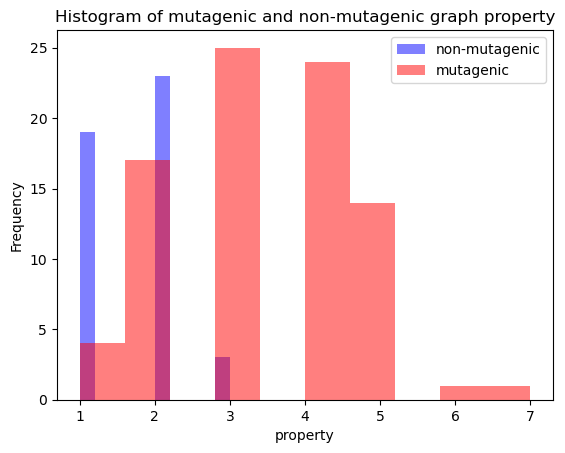

In [ ]:
# Plotting the distribution of the property across mutagenic and non-mutagenic graphs
plt.hist(G_train_property[np.array(y_train)==-1], color='blue', alpha=0.5, label='non-mutagenic')
plt.hist(G_train_property[np.array(y_train)==1], color='red', alpha=0.5, label='mutagenic')

plt.legend(['non-mutagenic','mutagenic'])

plt.xlabel('property')
plt.ylabel('Frequency')
plt.title('Histogram of mutagenic and non-mutagenic graph property')

plt.show()

**1.1.3 [3 pts]** **Suggest** 2 more graph features and compute them for all the graphs in the training set. **Motivate** the choice of features. You may use networkX implementation of the features computations if exist. **Train** a classifier using the `sklearn` library on the suggested features and the feature from the previous question (3 in total). Report the results for the test set. Don't forget to import the chosen classifier from the library.   

```markdown
Randić complexity index: it is an insightful graph property for assessing molecular complexity. It extends the concept of vertex degree by considering not just the immediate connections of an atom (vertex), but also the connectivity of its neighbors, and beyond, with diminishing weights. By summing these augmented degrees, which account for both local and extended topological features, the Randić index captures nuances of molecular structure that reflect how intricate a molecule is.
Spanning threes: they reflect the molecule's structural flexibility by counting all the acyclic ways atoms (vertices) can be interconnected. A higher number of spanning trees means more unique frameworks can be formed while maintaining molecular connectivity, revealing the molecule's potential for diverse conformations and stability under various conditions. This diversity, encapsulated in the count of spanning trees, is a robust measure of a molecule's topological complexity.
degree_centrality: can serve as a proxy for the complexity of a chemical compound. Compounds with higher degree centrality distributions across their constituent atoms tend to be more complex due to their increased connectivity and structural intricacy. Conversely, compounds with lower degree centrality distributions may be simpler or more straightforward in structure
...
```

In [86]:
def graph_property_radic(G: nx.Graph) -> float:
    randic_index = 0

    for vertex in G.nodes():
        vertex_degree = G.degree(vertex)
        augmented_degree = vertex_degree

        for distance in range(1, G.number_of_nodes()):
            neighbors_at_distance = nx.single_source_shortest_path_length(G, vertex, cutoff=distance)
            if distance in neighbors_at_distance.values():
                augmented_degree += (1 / (2 ** distance)) * sum(G.degree(n) for n, dist in neighbors_at_distance.items() if dist == distance)

        randic_index += augmented_degree

    return randic_index


In [87]:
from scipy.sparse.csgraph import laplacian # shouldn't be importing this


In [88]:
def graph_property_spanning(G: nx.Graph) -> float:
    G_undirected = nx.Graph(G) # only implemented for undirected
    L = laplacian(nx.to_scipy_sparse_matrix(G_undirected))
    eigenvalues = np.linalg.eigvals(L)
    non_zero_eigenvalues = [eig for eig in eigenvalues if eig > 1e-12]  # Avoiding numerical precision issues
    number_of_spanning_trees = np.prod(non_zero_eigenvalues) / len(G)

    return number_of_spanning_trees

In [89]:
def graph_property_centrality(G: nx.Graph) -> float:
  centrality = np.mean(list(nx.degree_centrality(G).values()))
  return centrality

In [46]:
G_train_trees = np.array([graph_property_spanning(G) for G in G_train])

C:\Users\giada\AppData\Local\Temp\ipykernel_15596\4106577993.py:3: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  L = laplacian(nx.to_scipy_sparse_matrix(G_undirected))


LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

c:\Users\USER\anaconda3\Lib\site-packages\numpy\lib\histograms.py:839: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
c:\Users\USER\anaconda3\Lib\site-packages\matplotlib\axes\_axes.py:6794: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


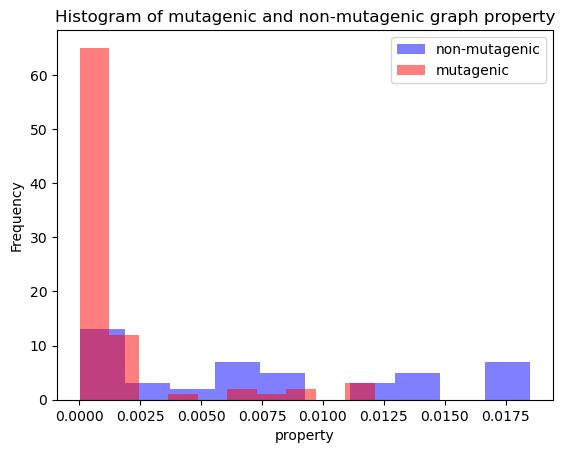

In [ ]:
# Plotting the distribution of the property across mutagenic and non-mutagenic graphs
plt.hist(G_train_trees[np.array(y_train)==-1], color='blue', alpha=0.5, label='non-mutagenic')
plt.hist(G_train_trees[np.array(y_train)==1], color='red', alpha=0.5, label='mutagenic')

plt.legend(['non-mutagenic','mutagenic'])

plt.xlabel('property')
plt.ylabel('Frequency')
plt.title('Histogram of mutagenic and non-mutagenic graph property')

plt.show()

In [90]:
G_train_radic = np.array([graph_property_radic(G) for G in G_train])

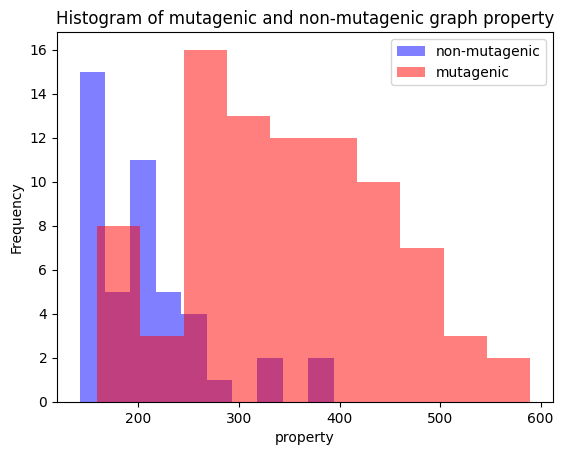

In [91]:
# Plotting the distribution of the property across mutagenic and non-mutagenic graphs
plt.hist(G_train_radic[np.array(y_train)==-1], color='blue', alpha=0.5, label='non-mutagenic')
plt.hist(G_train_radic[np.array(y_train)==1], color='red', alpha=0.5, label='mutagenic')

plt.legend(['non-mutagenic','mutagenic'])

plt.xlabel('property')
plt.ylabel('Frequency')
plt.title('Histogram of mutagenic and non-mutagenic graph property')

plt.show()

In [92]:
G_train_centrality = np.array([graph_property_centrality(G) for G in G_train])

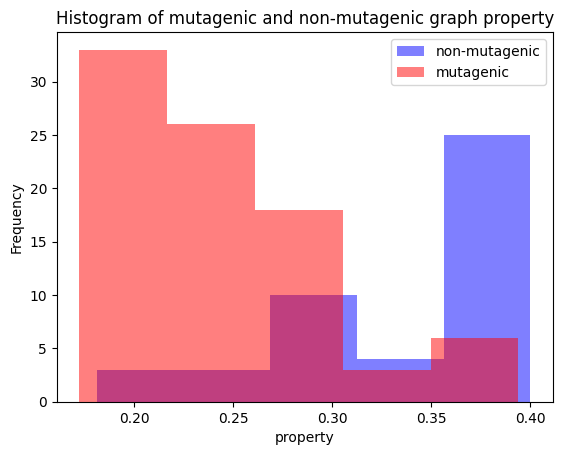

In [93]:
# Plotting the distribution of the property across mutagenic and non-mutagenic graphs
plt.hist(G_train_centrality[np.array(y_train)==-1], bins=5, color='blue', alpha=0.5, label='non-mutagenic')
plt.hist(G_train_centrality[np.array(y_train)==1], bins=5, color='red', alpha=0.5, label='mutagenic')

plt.legend(['non-mutagenic','mutagenic'])

plt.xlabel('property')
plt.ylabel('Frequency')
plt.title('Histogram of mutagenic and non-mutagenic graph property')

plt.show()

In [94]:
# Your solution here ###########################################################
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

G_train_radic = np.array([graph_property_radic(G) for G in G_train])
#G_train_trees = np.array([graph_property_spanning(G) for G in G_train])
G_train_cyclomatic = np.array([graph_property_centrality(G) for G in G_train])
F_train = np.column_stack((G_train_radic, G_train_cyclomatic))

G_test_radic = np.array([graph_property_radic(G) for G in G_test])
#G_test_trees = np.array([graph_property_spanning(G) for G in G_test])
G_test_cyclomatic = np.array([graph_property_centrality(G) for G in G_test])
F_test = np.column_stack((G_test_radic, G_test_cyclomatic))

pipeline = Pipeline([
    ('classifier', RandomForestClassifier(random_state=seed))
])
F_train_real = np.real(F_train)
F_test_real = np.real(F_test)
pipeline.fit(F_train_real, y_train)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

y_pred = pipeline.predict(F_test_real)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy with handcrafted graph features: {accuracy:.4f}")

Classification accuracy with handcrafted graph features: 0.9123


### Question 1.2: Graph kernels (18 pts)

### Graphlet Kernels

**1.2.1 [1 pts]** Read the following passage. It's from a study that investigated the MUTAG molecules and properties related to mutagenicity.
Given the results of the handcrafted features graph representation from the previous question, **suggest** what type of information that is important for the task at hand is not captured. **Answer:** would a kernel based method help in that case? **Explain**.


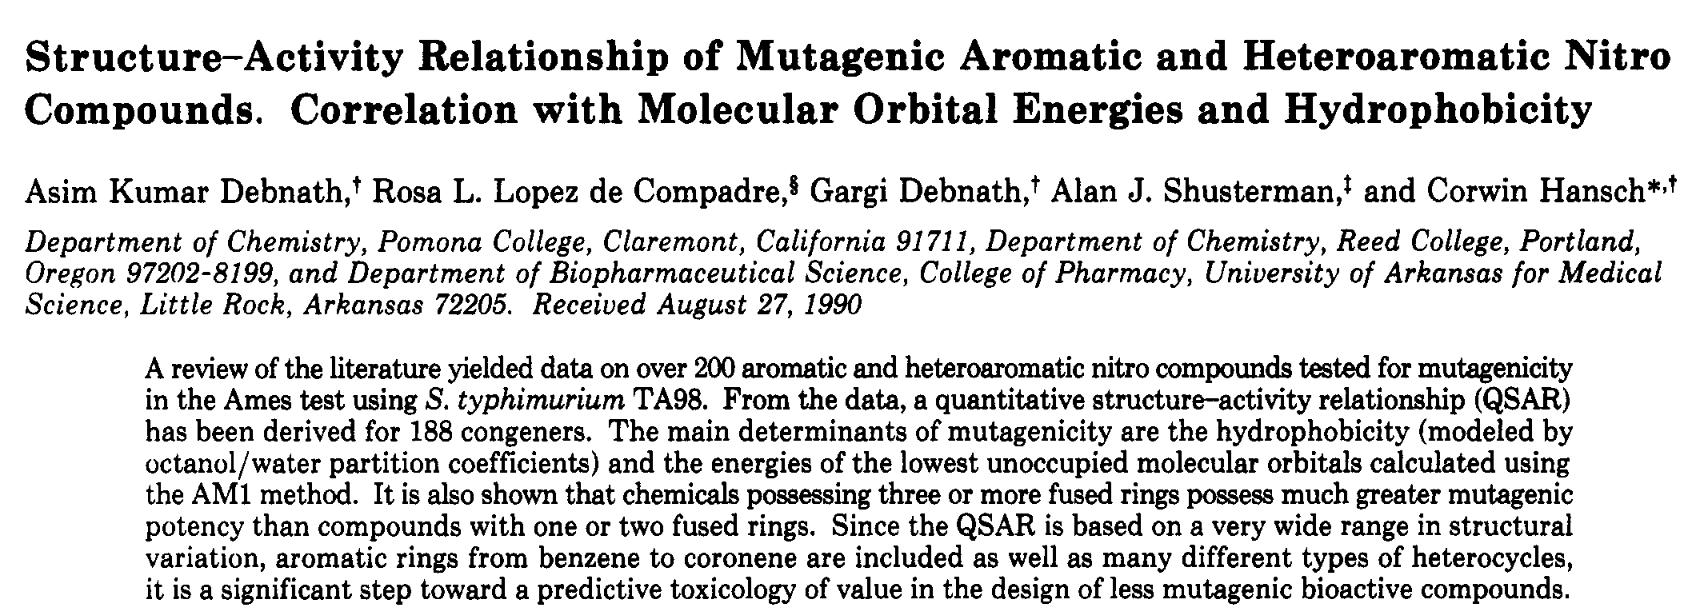


```markdown
What is missing is the number and structure of rings that are present in the molecules.

Moreover, mutagenic molecules typically include particular structures such as aromatic rings from benzene, coronene and heterocycles. The features selected earlier are derived from individual node attributes, lacking the capability to capture global graph structure properties. As a result, they may overlook critical patterns or characteristics present in the overall structure of the graph. Kernel based methods instead have the capability to identify local structural patterns inherent in mutagenic compounds, such as specific aromatic cycles. By leveraging kernels, we can capture the substructures within the molecules and therefore improve the accuracy of the classification between mutagenic and non-mutagenic.
...
```

**1.2.2 [2 pts]** Given the mutagenicity-relevant structures mentioned in the passage in q.1.1.2 is the relevant graphlet kernel computationally tractable? Explain by computing the complexity.*Hint: You can find some intuition in the following paper (section 3.1): https://proceedings.mlr.press/v5/shervashidze09a/shervashidze09a.pdf*
```markdown

Given the mutagenicity-relevant structures mentioned in the passage, the relevant graphlet kernel's computational tractability depends on the size and density of the graphs representing the chemical structures. For large and dense graphs, exhaustive enumeration of all graphlets is computationally infeasible as it scales as O(n^k), where n is the number of nodes and k is the size of the subgraphs (graphlets), which makes the problem untractable for large graphs, due to its prohibitive computational cost.
...
```

**1.2.3 [3 pts]** In the Servashidze et. al paper from the previous question they suggest to sample the graphlets (sections 3.1-3.2).

**Answer**

* What is the intuition behind the sampling?
* What would be a proper sample size for $k=3$ sized graphlets? **Estimate and explain**  



```markdown
The intuition behind sampling graphlets is to approximate the distribution of small subgraphs within a larger graph. This is akin to estimating a population parameter by using a sample. That means that a relatively small but well-chosen sample can provide a good approximation of the entire graph's subgraph distribution, which is particularly useful when dealing with large graphs, where enumerating all graphlets would be computationally expensive.
...

```

For $k=3$ sized graphlets, the proper sample size would depend on the desired level of confidence and precision. According to the theorem presented in the paper, for a given error margin $\epsilon$ (precision) and confidence level $1-\delta$, the sample size $m$ should satisfy the following:

$$ m \geq \frac{2}{\epsilon^2} \left( \log(2) \cdot a + \log\left(\frac{1}{\delta}\right) \right) $$

Here, $a$ represents the number of distinct graphlets. For $k=3$, there are oly 2 distinct graphlets (a line and a triangle).

If we desire a precision of 5% ($\epsilon = 0.05$) and a confidence level of 95% ($\delta = 0.05$), plugging these values into the formula gives:

$$ m \geq \frac{2}{0.05^2} \left( \log(2) \cdot 2 + \log\left(\frac{1}{0.05}\right) \right) = 3505.6$$

Meaning that we need at least 3506 samples to achieve the desired precision and confidence.

In [95]:
##################### i inverted your gamma and eps because eps is the one that should be on denominator
def sample_size(k: int, N: int, a: int, gamma=0.1, eps=0.1) -> float:
  '''
  k: graphlet size (#nodes)
  N: graph size (#nodes)
  a: number of unique (disconnected & connected) graphlets
  gamma: confidence level
  eps: margin of error
  '''
  # Your solution here #########################################################

  n_samples = 2 * (np.log(2)*a + np.log(1/gamma)) / (eps**2)
  # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  return n_samples

In [96]:
k = 3
# Your solution here #########################################################
N = 5 # it doesn't affect sampling
a = 4 # closed triangle, hat, one line connected, no line connected
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
sampling = sample_size(k, N, a, gamma=0.05, eps=0.05)
print(sampling)

4614.656796635017


**1.2.4 [3 pts]** Define $k=3,5$ graphlet kernel using the `grakel` library (already imported). For $k=5$ use the smallest number of samples from the paper as appears in Table2.   

**Train** a classifier with the calculated kernel. Make sure you import the classifier from `sklearn`.

#### Code for $k=3$:

In [97]:
# Initialize the Graphlet Sampling kernel
# Note: You can adjust 'k' (size of graphlets) and 'sampling' (number of samples) as needed

k = 3

# Your solution here ###########################################################
a = 4 # closed triangle, hat, one line connected, no line connected
n_samples = sample_size(k, N, a, gamma=0.05, eps=0.05)
n_samples = 1500

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

graphlet_kernel = GraphKernel(kernel={"name": "graphlet_sampling", "k": k, "sampling": {"n_samples": n_samples}}, normalize=True, random_state=seed)

# Convert networkX graphs to grakel
G_train_gk = graph_from_networkx(G_train)
G_test_gk = graph_from_networkx(G_test)


# Your solution here ###########################################################

K_train = graphlet_kernel.fit_transform(G_train_gk)
K_test = graphlet_kernel.transform(G_test_gk)

# Train a classifier on the training set
clf = RandomForestClassifier(random_state=seed) #don't forget to set random_state=seed
clf.fit(K_train, y_train)
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


# Predict the labels of the test set
y_pred = clf.predict(K_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy with Graphlet Sampling kernel: {accuracy:.4f}")

Classification accuracy with Graphlet Sampling kernel: 0.8421


#### Code for $k=5$:

In [98]:
k = 5

# Your solution here ###########################################################
# connected graphlets: 29
# unconnected graphlets: 
n_samples = 1500
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
graphlet_kernel = GraphKernel(kernel={"name": "graphlet_sampling", "k": k, "sampling": {"n_samples": n_samples}}, normalize=True, random_state=seed)

# Convert networkX graphs to grakel
G_train_gk = graph_from_networkx(G_train)
G_test_gk = graph_from_networkx(G_test)


# Your solution here ###########################################################

K_train = graphlet_kernel.fit_transform(G_train_gk)
K_test = graphlet_kernel.transform(G_test_gk)

# Train a classifier on the training set
clf = RandomForestClassifier(random_state=seed) #don't forget to set random_state=seed
clf.fit(K_train, y_train)


# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


# Predict the labels of the test set
y_pred = clf.predict(K_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy with Graphlet Sampling kernel: {accuracy:.4f}")

Classification accuracy with Graphlet Sampling kernel: 0.7895


**1.2.5 [1 pts]** Which graphlet kernel performed better? **Suggest an explanation**

```markdown
The kernel with k = 3 performed slightly better. This is probably due to the fact that k = 5 captures only more complicated structures, which can lead to overfitting and a decrease of testing performance

I think that k = 5 requires more samples to perform better

...
```

### Other Kernels

**1.2.6 [2 pts]** One of the downsides of the aforementioned implementation of graphlet kernels is that it doesn't take into account node labels. In the MUTAG dataset we have access to those labels. **Suggest** another kernel that can take into account the node labels and is also computationaly efficient. **Motivate** your choice.

```markdown
**Your answer here:**
...
```

In [55]:
# Let's add nodes labels to the G_train and G_test graphs
with open('MUTAG/MUTAG_node_labels.txt', 'r') as f_nodes:
      node_labels = [int(line.strip()) for line in f_nodes]

for G in G_train:
  for n in G.nodes:
    G.nodes[n]['label'] = node_labels[n-1]

for G in G_test:
  for n in G.nodes:
    G.nodes[n]['label'] = node_labels[n-1]

**1.2.7 [2 pts]**  **Define** the kernel in the code block below and **train** a classifier using it.

In [64]:
from sklearn.svm import SVC # support vector classifier ?
#SVC better than randomforest

In [68]:
# Your solution here ###########################################################
# Initialize the kernel

# the dots indicate parameters of the kernel to be defined

kernel = GraphKernel(kernel=[{"name": "weisfeiler_lehman"}],normalize = True,random_state=seed)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
G_train_gk = graph_from_networkx(G_train, node_labels_tag='label')
G_test_gk = graph_from_networkx(G_test, node_labels_tag='label')


# Your solution here ###########################################################

# Compute the kernel matrix
K_train = kernel.fit_transform(G_train_gk)
K_test = kernel.transform(G_test_gk)

# Train a classifier on the training set
clf = SVC(random_state=seed)#don't forget to set random_state=seed
clf.fit(K_train, y_train) # do i have to set the label if the kernel is already including it

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# Predict the labels of the test set
y_pred = clf.predict(K_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy with chosen kernel: {accuracy:.4f}")


Classification accuracy with chosen kernel: 0.8772


**1.2.8 [3 pts]** Let's investigate the performance of the kernel without the node labels, i.e, its ability to capture structural similarity solely. In order to do that we first assign arbitrary labels (=1) to the nodes.

In the code block **define** again the kernel from the previous question and **train** a classifier.

In the text box **answer**: does the suggested kernel outperform the graphlet kernel? If it does, try to explain. If it doesn't, explain and try to suggest an improvement. You may search in the literature.

In [59]:
# Let's add arbitrary nodes labels to factor out nodes information
with open('MUTAG/MUTAG_node_labels.txt', 'r') as f_nodes:
      node_labels = [int(line.strip()) for line in f_nodes]

for G in G_train:
  for n in G.nodes:
    G.nodes[n]['label'] = 1

for G in G_test:
  for n in G.nodes:
    G.nodes[n]['label'] = 1

In [71]:
# Your solution here ###########################################################
# Initialize the kernel

# the dots indicate parameters of the kernel to be defined
kernel = GraphKernel(kernel=[{"name": "weisfeiler_lehman"}],normalize=True, random_state=seed)


# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
G_train_gk = graph_from_networkx(G_train, node_labels_tag='label')
G_test_gk = graph_from_networkx(G_test, node_labels_tag='label')


# Your solution here ###########################################################

# Compute the kernel matrix
K_train = graphlet_kernel.fit_transform(G_train_gk) # kernel matrix
K_test = graphlet_kernel.transform(G_test_gk)

# Train a classifier on the training set
clf = SVC(random_state=seed)#don't forget to set random_state=seed
clf.fit(K_train, y_train)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# Predict the labels of the test set
y_pred = clf.predict(K_test)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy with chosen kernel: {accuracy:.4f}")

Classification accuracy with chosen kernel: 0.8772


In [72]:
#core_framework= accuracy 0.8

```markdown
**Your answer here:**

...

```

**1.2.9 [1 pts]** Given the performance of the handcrafted features and the kernels in the MUTAG classification task, **suggest** another kernel that you expect to perform well and **explain** your choice. *Hint: you may go over the list of implemented kernels in the `grakel` library to get some intuition.*

```markdown
**Your answer here:**
...
```

# **Part 2: K-hop Selection [6 pts]**

# Objective:

In this part you will get an intuition about the usefulness of the power of the adjacency matrix and their relation to the receptive field of a graph. This is important for future work on graph representation learning if we deal with large graphs or graphs with distant dependencies among nodes, in which more than one-hop neighborhood needs to be considered.

**2.1 [3 pts]** Given a graph G consisting of *n* nodes, write a function that takes as input G, an integer k, and a randomly selected node *i*, and returns the nodes positioned at the k-th hop neighborhood of node *i*. You need to use the powers of the adjacency matrix as part of the solution.

Nodes at 2-th hop neighborhood of node 6: [ 2  3  4  6  7 10 13 14 15 17]


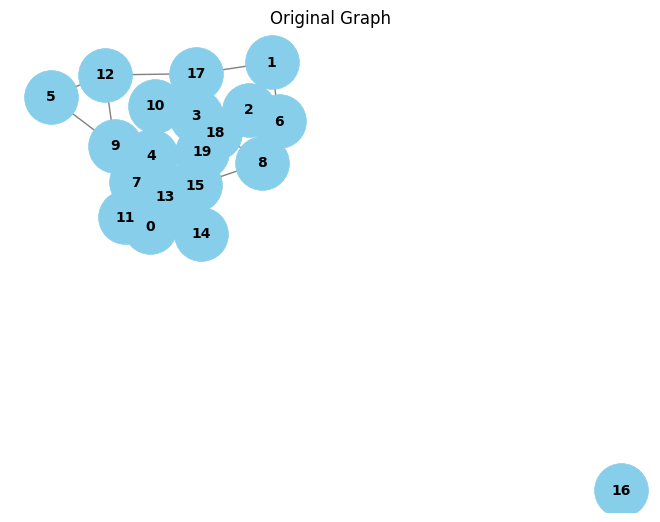

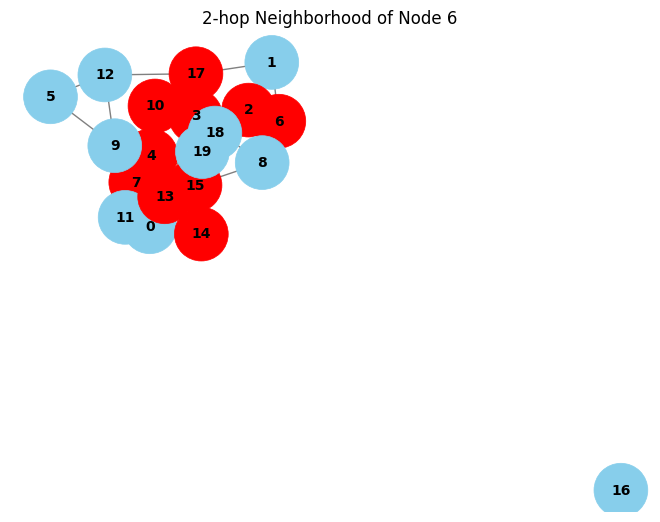

In [104]:
def k_hop_neighborhood(adj_matrix, node_index, k):
    # Your solution here ###########################################################
    result = np.linalg.matrix_power(adj_matrix, k)
    neighbors_at_k_hop = np.where(result[node_index] > 0)[0]
    adj_power = k

    # ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    return neighbors_at_k_hop,adj_power

# Generate a random graph using NetworkX
G = nx.fast_gnp_random_graph(20, 0.2)

# Convert the graph to an adjacency matrix
adj_matrix = nx.to_numpy_array(G)

# Choose the node index and hop distance

"""
Example- Test with different values of node index and k below.
"""
node_index = 6
k = 2

# print(adj_matrix)

# Find nodes at the k-th hop neighborhood
neighborhood,power = k_hop_neighborhood(adj_matrix, node_index, k)
print(f"Nodes at {k}-th hop neighborhood of node {node_index}: {neighborhood}")

# Visualize the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=10, font_weight='bold', linewidths=0.5, edge_color='gray')
plt.title('Original Graph')
plt.show()

# Highlight the nodes at k-hop neighborhood
nodes_to_highlight = [node_index] + list(neighborhood)
node_colors = ['red' if node in nodes_to_highlight else 'skyblue' for node in range(len(adj_matrix))]
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1500, font_size=10, font_weight='bold', linewidths=0.5, edge_color='gray')
plt.title(f'{k}-hop Neighborhood of Node {node_index}')
plt.show()

**2.2 [3 pts]** Given the graph G above, define random node features of any size d (e.g d=32) for each node of the graph. Now extend the function above to select nodes from random hops relative to each node i, and sum the node embeddings to update node i's features. (i.e if the graph has 20 nodes, define 20 random vectors of size d=32. Then given a node A at position i, select nodes from 2 random hops, say 1 and 3. Now sum the random features of these nodes, and sum them again with node A's initial features)

Nodes at 1-th hop neighborhood of node 6: [ 4  9 14]


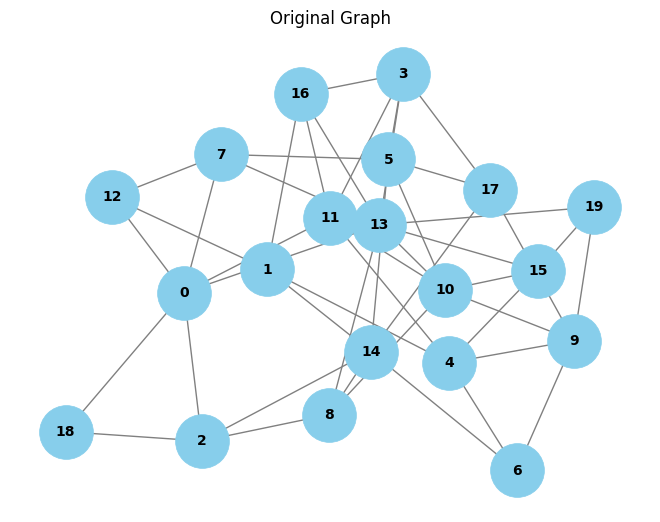

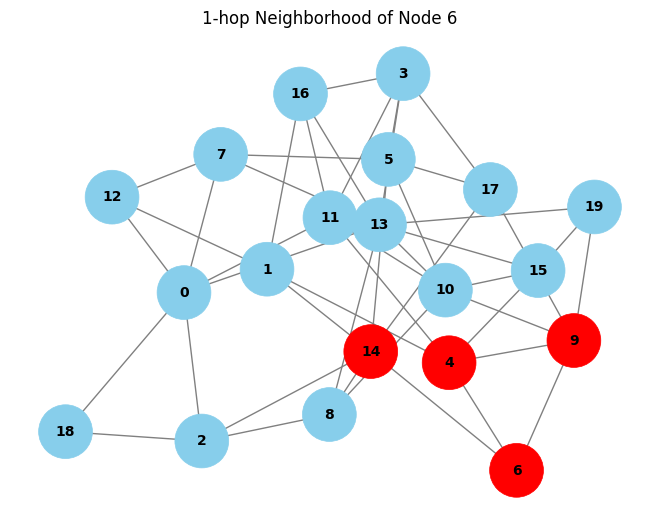

Nodes at 2-th hop neighborhood of node 6: [ 1  2  4  5  6  8  9 10 11 15 17 19]


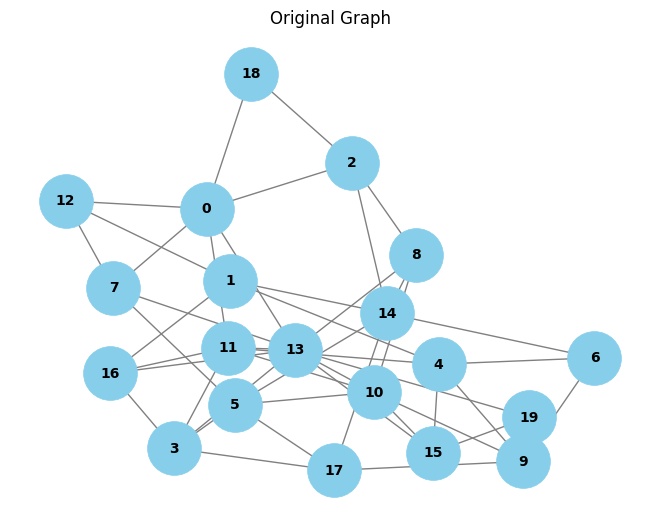

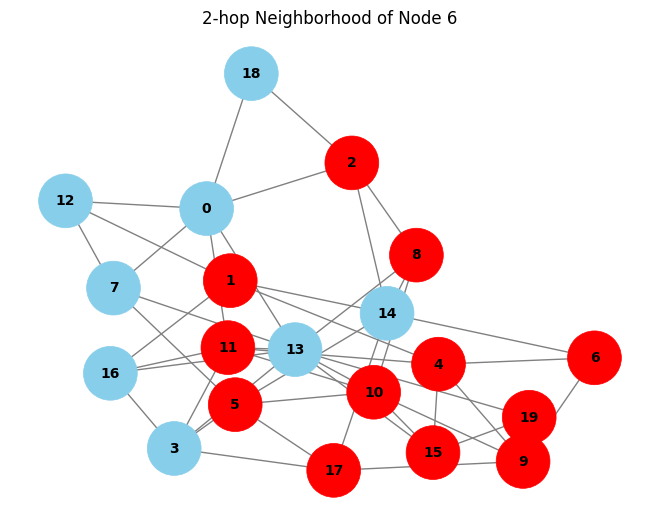

Nodes at 3-th hop neighborhood of node 6: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


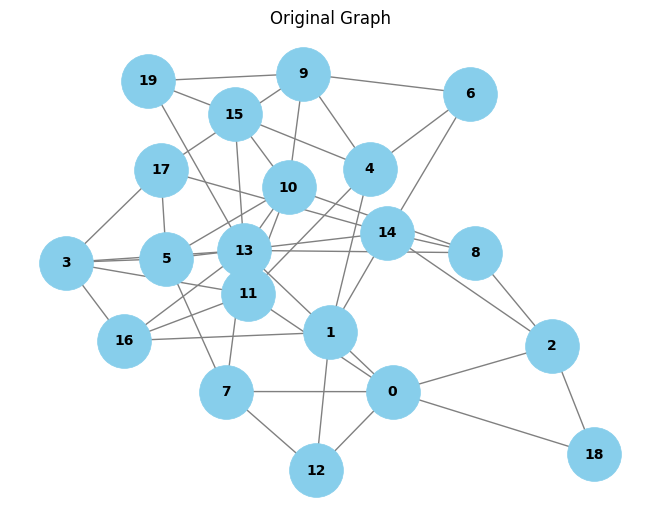

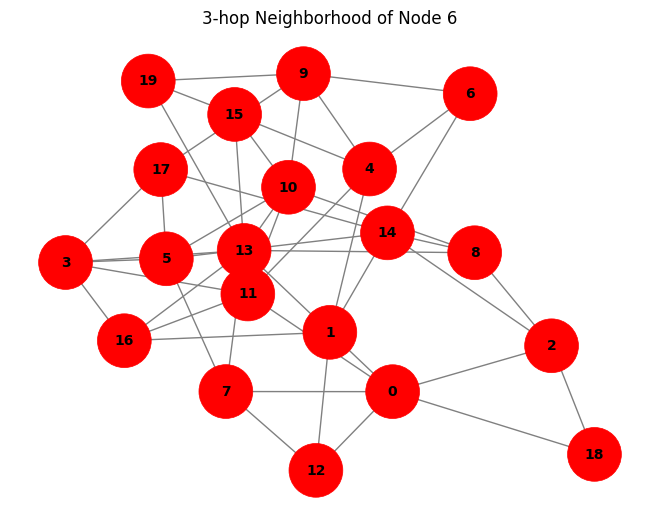

In [105]:
import numpy as np

def k_hop_neighborhood_sampling(adj_matrix, node_index, k, d=32):
    node_features = np.random.rand(adj_matrix.shape[0], d)
    reachable = sum(np.linalg.matrix_power(adj_matrix, i) for i in range(1, k + 1))
    reachable_at_k_or_less_hops = np.where(reachable[node_index] > 0)[0]
    reachable_at_k_or_less_hops = np.append(reachable_at_k_or_less_hops, node_index)
    unique_nodes = np.unique(reachable_at_k_or_less_hops)
    new_node_features = np.sum(node_features[unique_nodes], axis=0)

    return new_node_features

# Generate a random graph using NetworkX
G = nx.fast_gnp_random_graph(20, 0.2)

# Generate random node embeddings for each node in the graph

# Your solution here ###########################################################
features = np.random.rand(20, 2)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

# Convert the graph to an adjacency matrix
adj_matrix = nx.to_numpy_array(G)

# Choose the node index and hop distance

"""
Example- Test with different values of node index.
"""
node_index = 6
K = [1,2,3]

for k in K:
    # Find nodes at the k-th hop neighborhood
    neighborhood,power = k_hop_neighborhood(adj_matrix, node_index, k)
    print(f"Nodes at {k}-th hop neighborhood of node {node_index}: {neighborhood}")

    # Visualize the graph
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1500, font_size=10, font_weight='bold', linewidths=0.5, edge_color='gray')
    plt.title('Original Graph')
    plt.show()

    # Highlight the nodes at k-hop neighborhood
    nodes_to_highlight = [node_index] + list(neighborhood)
    node_colors = ['red' if node in nodes_to_highlight else 'skyblue' for node in range(len(adj_matrix))]
    nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=1500, font_size=10, font_weight='bold', linewidths=0.5, edge_color='gray')
    plt.title(f'{k}-hop Neighborhood of Node {node_index}')
    plt.show()

# **Part 3: Node Classification [28 pts]**

## Objective

The purpose of this assignment is to explore the usefulness of hand-crafted features and learned features with node2vec in a supervised learning setting applied to the tasks of **node-labelling**.

The dataset we will use for this assignment is the Polblogs dataset. The Political Blogs dataset from the “The Political Blogosphere and the 2004 US Election: Divided they Blog” paper. Polblogs is a graph with 1,490 vertices (representing political blogs) and 19,025 edges (links between blogs). The links are automatically extracted from a crawl of the front page of the blog. Each vertex receives a label indicating the political leaning of the blog: liberal or conservative.

In [1]:
# Download the package we will use
from IPython.display import clear_output
clear_output()

In [2]:
# Download the node2vec package we will use
# Run this cell to kill the current runtime after downloading 'node2vec', so a package version conflict about 'gensim' when using 'node2vec' can be avoided
# Run all again after commenting out this cell completely
run_cell = False
if run_cell:
  import os
  from IPython.display import clear_output
  !pip install node2vec
  clear_output()
  os.kill(os.getpid(), 9)


In [ ]:
#!pip install node2vec

In [3]:
# import useful libraries

from node2vec import Node2Vec
%matplotlib inline
%env PYTHONHASHSEED=0
from IPython.display import clear_output
clear_output()

First of all, we can download the dataset and retrieve the characteristics of the network in the following cells.

In [ ]:
#!pip install torch

In [4]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

from torch_geometric.datasets import PolBlogs
dataset = PolBlogs(root='./')


2.2.1+cpu


In [5]:
num_feats=dataset.num_node_features
num_classes=dataset.num_classes

In [6]:
dataset[0]

Data(edge_index=[2, 19025], y=[1490], num_nodes=1490)

In [7]:
# Convert PyTorch Geometric graph to NetworkX graph
from torch_geometric.utils.convert import to_networkx
G = to_networkx(dataset[0],node_attrs='y')

In [11]:
# Print the number of nodes and edges within the dataset
number_of_nodes = G.number_of_nodes()
print('Number of nodes (teams): {}' .format(number_of_nodes))
number_of_edges = G.number_of_edges()
print('Number of edges (egular-season games): {}' .format(number_of_edges))

# Retrieve the labels of nodes in the dataset
values = nx.get_node_attributes(G, "y")
labels = np.unique([values[node] for node in G.nodes()])
print('The node labels are: {}' .format(labels))

Number of nodes (teams): 1490
Number of edges (egular-season games): 19025
The node labels are: [0 1]


In [13]:
# Load the nodes with each label into a set of node lists
node_list = {}
node_list = [[n for n, v in values.items() if v == l] for l in labels]

# Load the edges between nodes with same/different labels into lists
edge_list_same = [[(s, d) for (s, d) in G.edges() if s in node_list[l] and d in node_list[l]] for l in labels]
edge_list_same_all = []
for l in labels:
  edge_list_same_all += edge_list_same[l]
edge_list_diff = [(s, d) for (s, d) in G.edges() if (s, d) not in edge_list_same_all]

# Show the nodes within each class
print('The labels of each node are:')
for l in labels: print(node_list[l])

The labels of each node are:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 

Now let's visualize dataset, i.e., the graph connectivity of the nodes, and the node labels.

c:\Users\USER\anaconda3\Lib\site-packages\networkx\drawing\nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


 ...]

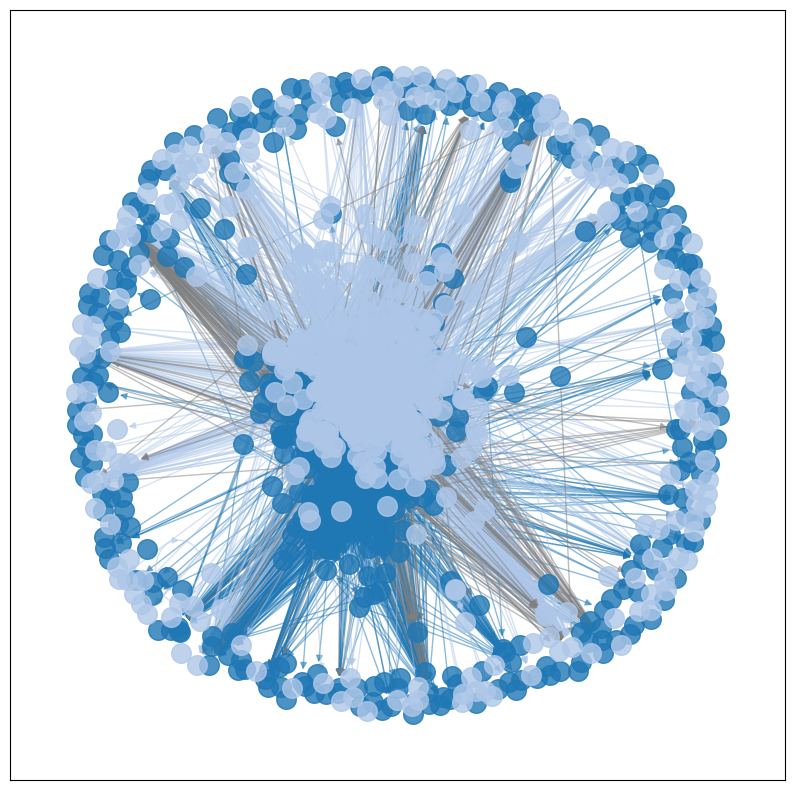

In [ ]:
# Visualize the graph structure; nodes and edges within different classes (labels) are in different colors
cm = plt.cm.tab20
pos = nx.spring_layout(G, seed=0)
plt.figure(figsize=(10,10))

for l in labels:
  nx.draw_networkx_nodes(G, pos, nodelist= node_list[l], node_color=cm(l), node_size=200, alpha=0.8)
  nx.draw_networkx_edges(G, pos, edgelist = edge_list_same[l], width=1.0, alpha=0.5, edge_color=cm(l))
nx.draw_networkx_edges(G, pos, edgelist = edge_list_diff, width=1.0, alpha=0.5, edge_color="tab:gray")

In this section, you will perform a node-labelling or classification task. You will do this in two different settings:

(a) Using traditional features of degree, eigenvector centrality,
  betweenness centrality,
  closeness centrality, and the
  clustering_coefficients, to train a an SVM classifier

(b)  Using node2vec features to train a an SVM classifier

You can use the sklearn library for this task.


### **3.1 On choice of node features [4 pts]**

(a) Can you think of 5 hand-crafted node features (discussed in the theory lectures) that would be the most helpful to the task of node prediction for this dataset? Please motivate your choice in few sentences.

(b) Between the hand-crafted features and node2vec features, which do you think would be better predictors? Please motivate your answer.


```markdown
**Your answer here:**

The node degree provides a fundamental indication of how connected a node is within the network. It quantifies the number of edges directly linked to the node, offering a basic measure of its immediate influence.

Betweenness centrality quantifies how often a node lies on the shortest paths between other nodes, reflecting its position as a bridge or intermediary within the network. This metric provides insight into how centrally located a node is in facilitating communication between other nodes.

Closeness centrality instead, offers insights into a node's proximity to all other nodes in the network. Nodes with high closeness centrality have shorter average distances to other nodes.

The eigenvector evaluates a node's importance by considering not only its direct connections but also the connections of its neighbors. Nodes with high eigenvector centrality are those surrounded by well-connected neighbors, highlighting their importance.

By measuring the extent of clustering or interconnectedness among a node's neighbors, the global clustering coefficient provides insights into the local structure surrounding the node. Nodes with high clustering coefficients are more likely to be part of tightly-knit clusters or communities within the network.
...
```

As previously mentioned in part 1 the problem with the node features is that they often are not able to caputure the complexity of the and particular subgraphs strucutres. In contrary node2features should be able to capture 

### **3.2: Data Extraction [3 pts]**


**3.2.1  Node Feature Extraction [2 pts]**
Extract the 5 traditional/hand-crafted features you chose in the earlier question and form a 5-dimensional feature vector for every node in the following cell.

In [14]:
from networkx.algorithms.bipartite.centrality import betweenness_centrality
def node_feature_extraction(G):
  '''
  INPUT:
  G: the graph

  OUTPUT:
  features: feature matrix of dimensions (N, D) (N: number of samples; D: number of features)
  '''
# Your solution here ###########################################################
  features = [
    list(nx.degree_centrality(G).values()),
    list(nx.eigenvector_centrality(G).values()),
    list(nx.betweenness_centrality(G).values()),
    list(nx.closeness_centrality(G).values()),
    list(nx.clustering(G).values())
  ]

  features = np.stack([np.array(feature) for feature in features])

  print(features.T.shape)

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  return features.T

**3.2.2  Node Target and Label Extraction [1 pts]**
Extract the node targets and all their possible labels in the following cell.

In [15]:
def node_target_extraction(G):
  '''
  INPUT:
  G: the graph

  OUTPUT:
  targets: target vector of dimensions (N, ) (N: number of samples)
  labels: vector of all possible labels for nodes in the graph
  '''

  targets = np.array([G.nodes[node]['y'] for node in G.nodes()]) # Your solution here ###########################################################
  labels = np.unique(targets) # Your solution here ###########################################################
  return targets, labels

Let's implement and test your feature and target extraction modules in the cell below.

In [16]:
features_node = node_feature_extraction(G)
targets_node, labels_node = node_target_extraction(G)

(1490, 5)


### **3.3: Classification Module [5 pts]:**

Design a classifier function by integrating modules including:

1. **Data spliting**: Split dataset into train and test sets (50% - 50%). Make sure the data partition is stratified.

2. **Feature selection**: Implement a feature selection preprocessing step before training to use the k highest scored features for the classification task. You might find `SelectKBest` and `f_classif` in `sklearn.feature_selection` helpful.

3. **Normalization**: Normalize the features after feature selection and before training.

4. **Support-vector based classifier**. You might find `svm.SVC` helpful. Please set `class_weight='balanced'`.

5. **Evaluation**: Implement prediction on the test set. Show the performance using weighted f1 score, and display the confusion matrix. You might find `sklearn.metrics.ConfusionMatrixDisplay` helpful.

*** Please set all `random_state=0` and `seed=0` for reproducibility.**

** This function will be used both for node classification and link prediction in the following parts.

In [2]:
# giada
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

def classifier(features, targets, labels, feature_selection=False, num_features=1, test_size=0.5, seed=0, verbose=False):
  '''
  INPUT:
  features: feature matrix of dimensions (N, D) (N: number of samples; D: number of features)
  targets: target vector of dimensions (N, ) (N: number of samples)
  labels: vector of all possible labels for nodes in the graph
  feature_selection: a flag for whether to use feature selction, bool
  num_features: number of features used from feature selesction
  test_size: please set to 0.5 for reproducibility
  seed: please set to 0 for reproducibility
  verbose: print and plot result or not, bool

  OUTPUT:
  cm: confusion matrix on the test set
  f1: weighted f1 score on the test set

  ** Please set all of the random_state=seed in following module **
  '''

  # Split the data into training and testing sets, with test_size=0.5
  # Your solution here ###########################################################
  X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=test_size, random_state=seed, stratify = targets)
    #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  # normalize
  X_train = StandardScaler().fit_transform(X_train)
  X_test = StandardScaler().fit_transform(X_test)

  # select the k most relevant features
  selector = SelectKBest(score_func=f_classif, k=num_features)
  selector.fit(X_train, y_train)
  feature_scores = selector.scores_

  if feature_selection:
    ## Your solution here ###########################################################
    ## Build and train the ML model, including feature selection, normalization and Support Vector Classifier. Select the k highest relevant features for the classification.

    selected_features_indices = selector.get_support(indices=True)

    X_train_selected = X_train[:, selected_features_indices]
    X_test_selected = X_test[:, selected_features_indices]

    # model:
    clf = svm.SVC(kernel='linear')
    clf.fit(X_train_selected, y_train)
    y_pred = clf.predict(X_test_selected)

    cm = metrics.confusion_matrix(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')

    ## Print the scores for individual features.

    ##^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  else:
    ## Your solution here ###########################################################
    ## Build and train the ML model, including normalization and Support Vector Classifier.

    # model:
    clf = svm.SVC(kernel='linear')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    cm = metrics.confusion_matrix(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')

    ##^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  # Your solution here ###########################################################
  # Use the model to predict the labels of the test data
    y_pred = clf.predict(X_test)
    cm = metrics.confusion_matrix(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred, average='weighted')
  # Output the confusion matrix and weighted f1 score on the test set. Print the weighted f1 score and plot the confusion matrix if verbose


  # Plot the confusion matrix if verbose
  if verbose:
    centrality_labels = ["Degree Centrality", "Eigenvector Centrality", "Betweenness Centrality", "Closeness Centrality", "Clustering Coefficient"]
    print("Feature Scores:\n")
    for i in range(len(feature_scores)):
      print(f' {i+1}: {feature_scores[i]:.4f}')

    print("Weighted F1 Score:", f1)
    print("Confusion Matrix:\n", cm)

  #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  return cm, f1

### **3.4: Node Classification Using Handcrafted Features [4 pts]:**

**3.4.1  Node Classification without Feature Selection [3 pt]**

Train the classifier without feature selection (using all the 5 features) and show the output.

In [18]:
cm, f1 = classifier(features_node, targets_node, labels_node, feature_selection=False, num_features=1, test_size=0.5, seed=0, verbose=True)

Feature Scores:

 1: 4.2517
 2: 23.3072
 3: 0.4724
 4: 37.9877
 5: 0.0333
Weighted F1 Score: 0.6523489932885906
Confusion Matrix:
 [[243 136]
 [123 243]]


Then train the classifier with feature selection with top 3 features and show the output including the feature scores.

In [19]:
cm, f1 = classifier(features_node, targets_node, labels_node, feature_selection=True, num_features=3, test_size=0.5, seed=0, verbose=True)

Feature Scores:

 1: 4.2517
 2: 23.3072
 3: 0.4724
 4: 37.9877
 5: 0.0333
Weighted F1 Score: 0.6561665144051403
Confusion Matrix:
 [[238 141]
 [115 251]]


**3.4.2  Find the best number of features selected [1 pt]**
With respect to the weighted f1 score, which is the best number of K chosen for the classification performance on the test set? Show the results using different K into a plot and find the best number of K.

In [20]:
features_node.shape

(1490, 5)

The best K with respect to weighted f1 score is: 2
The f1 score is: 0.6561665144051403


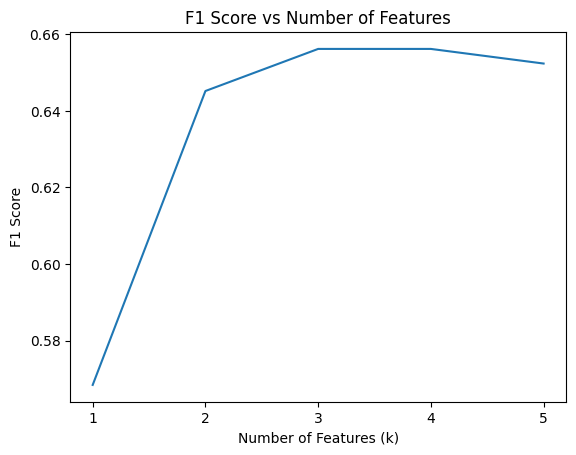

In [21]:
# Plot the weighted f1 score using different number of best K features in a figure, and print out the best number of K
'''
  k_best: the best number of K with respect to weighted f1 score on the test set
'''
# Your solution here ###########################################################
k_best = None
max_f1 = 0
K = np.arange(1,features_node.shape[1]+1)
f1_values = []
for k in K:
  cm, f1 = classifier(features_node, targets_node, labels_node, feature_selection=True, num_features=k, test_size=0.5, seed=0)
  f1_values.append(f1)
max_f1 = np.max(f1_values)
k_best = np.argmax(f1_values)

# plot of f1 values vs number of features
plt.plot(K, f1_values)
plt.xticks(np.arange(1, len(K)+1, step=1))
plt.xlabel('Number of Features (k)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Number of Features')

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
print("The best K with respect to weighted f1 score is: {}".format(k_best))
print("The f1 score is: {}".format(max_f1))

**3.4.3  Explanations for the Best Features [1 pt]**
**Q:** What are the best top K features selected in your implementation? Could you please give an possible explanation for why they play important roles in our node classification task?

```markdown
**Your answer here:**
...
```



### **3.5: Node2vec features [11 pts]**

**3.5.1  Node2Vec Basics [1 pt]**

**Q:** Explain the main components of the Node2vec embedding and discuss in short the relevance of the parameters walk length, p, and q, used in the embedding.



```markdown
**Your answer here:**

Node2Vec operates by capturing the inherent structure of a graph through a two-step process involving random walks and node embeddings

p,q are called the return parameter and the in-out parameter respectively and they serve to create a biased randowwalk determining how fast the walk explores and leaves the neighbourhood of a starting node u.
p Controls the likelihood of returning to the previous node in a random walk. A higher value biases the walk towards revisiting recent locations, promoting the exploitation of local structures.
q governs the likelihood of moving away from the previous node. A lower value encourages exploration, allowing the walk to move towards nodes further away.

the walk length determines the length of each random walk. A longer walk captures more global information, while a shorter walk focuses on local neighbourhoods.  

number of walks: this represents the number of random walks initiated from each node. Increasing this number enhances the exploration of the graph.
...
```

**3.5.2 About node2vec parameters [3 pts]**

**Q:** As you know node2vec has two parameters p and q.
Which configuration of these parameters do you think best suits this task?
low/low, low/high, high/low, or high/high?

Please motivate your answer.


```markdown
**Your answer here:**
 Given that the chemical compounds in our dataset do not consist of graphs with a large number of nodes, and our interest lies in specific local structures such as particular aromatic cycles, we prioritize local exploration. Hence, the optimal configuration for the task would lean towards a biased random walk with a low p-value and a high q value. Such walks enable us to attain a local perspective of the underlying graph concerning the starting node.
```


**3.5.3  Node2Vec Node Feature Extraction [1 pt]**

Extract the node2vec features of nodes using the `node2vec.Node2Vec`.

*** Please set `random_state=0` and `seed=0` for reproducibility.**




In [ ]:
def Node2Vec_node_feature_extraction(G, num_features=1, p=1.0, q=1.0, seed=0):
  '''
  INPUT:
  G: the graph
  num_features: dimension of node2vec embeddings, int
  p: float
  q: float
  seed: please always set to 0

  OUTPUT:
  features: feature matrix of dimensions (N, D) (N: number of samples; D: dimension of Node2Vec embeddings)
  '''
  #
  # Your solution here ###########################################################
  num_walks = 100# lower should be ok
  
  node2vec = Node2Vec(G, dimensions=num_features, walk_length=20, num_walks=100, workers=2, p=p, q=q, seed=seed)
  model = node2vec.fit(window=5, min_count=5, batch_words=2)
  features = np.array([model.wv.get_vector(str(node)) for node in G.nodes()])
  #^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  return features

**3.5.4  Implement node classification using Node2Vec [2 pts]**

Let's implement your Node2Vec based classification by setting `num_features=3, p=1.0, q=0.1`

In [ ]:
# Implement Node2Vec by setting:
# num_features=3, p=1.0, q=0.1
features_node2vec = Node2Vec_node_feature_extraction(G, num_features=3, p=1.0, q=0.1, seed=0)
# Your solution here ###########################################################
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Computing transition probabilities:   5%|▌         | 75/1490 [00:00<00:05, 237.77it/s]

Computing transition probabilities: 100%|██████████| 1490/1490 [00:03<00:00, 417.94it/s]



Let's change your parameters to `q=10.0` and implement your results.

In [ ]:
# Implement Node2Vec by changing:
# q=10.0
# Your solution here ###########################################################
features_node2vec = Node2Vec_node_feature_extraction(G, num_features=3, p=1.0, q=10, seed=0)
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Computing transition probabilities: 100%|██████████| 1490/1490 [00:03<00:00, 416.39it/s]


In [ ]:
features_node2vec_5feat = Node2Vec_node_feature_extraction(G, num_features=5, p=1.0, q=10, seed=0) # shape (1490,5)

Computing transition probabilities: 100%|██████████| 1490/1490 [00:04<00:00, 304.29it/s]


**3.5.5  Parameters in Node2Vec [2 pts]**

**Q:** What difference do you observe in both classifiers? Why do you think this difference exists by changing this parameter?



```markdown
**Your answer here:**
...
```

**Q:** What might be other parameters that we can change in Node2Vec to improve our classification performance? Try to change this parameter and implement in the cell below to achieve a better performance than above.

```markdown
**Your answer here:**
...
```

In [ ]:
# Implement Node2Vec by changing your chosen parameter and try to achieve a better performance
# Your solution here ###########################################################

#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

**3.5.6  Comparing Hand-crafted and Node2Vec Features [2 pts]**

Now we can combine the hand-crafted features and node2vec embeddings together. Use the 5 hand-crafted features and 5-dimensional node embeddings. Construct them into 10-dimensional features and implement them into the classifier with top-3 scored features and show the feature scores in the following cell.

*** Please set `seed=0`, `p=1.0` and `q=10.0` for reproducibility.**

In [ ]:
# Implement Node2Vec and combine them with hand-crafted features then use them for classification
# Your solution here ###########################################################
features_node_combined = np.concatenate((features_node, features_node2vec_5feat), axis=1) # shape(1490, 10)
cm, f1 = classifier(features_node_combined, targets_node, labels_node, feature_selection=True, num_features=3, test_size=0.5, seed=0, verbose=True)
#^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Feature Scores:

 1: 4.2517
 2: 23.3072
 3: 0.4724
 4: 37.9877
 5: 0.0333
 6: 1213.0036
 7: 97.3982
 8: 0.0547
 9: 2.2172
 10: 0.3683
Weighted F1 Score: 0.8770764337279996
Confusion Matrix:
 [[360  19]
 [ 72 294]]


According the results you showed above, which group of features between hand-crafted and Node2Vec are scored better in general? Could you give an explanation for why this group of features are scored higher than the others and are better predictors in the classifier?

```markdown
**Your answer here:**
...
```